# 02. Neural Network Classification with PyTorch

Classification is a problem of predicting whether something is one thing or another (there can be multiple things as the options).

Book version of thins notebook - https://www.learnpytorch.io/02_pytorch_classification/

All other resources - https://github.com/mrdbourke/pytorch-deep-learning


## 1. Make classification data and get it ready

In [1]:
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

In [2]:
len(X), len(y)

(1000, 1000)

In [3]:
print(f"First 5 samples of X:\n {X[:5]}")
print(f"First 5 samples of y:\n {y[:5]}")

First 5 samples of X:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y:
 [1 1 1 1 0]


In [4]:
# Make dataframe of circle data
import pandas as pd
circles = pd.DataFrame({"X1":X[:,0], "X2":X[:,1], "label":y})
circles

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
...,...,...,...
995,0.244054,0.944125,0
996,-0.978655,-0.272373,0
997,-0.136900,-0.810012,1
998,0.670362,-0.767502,0


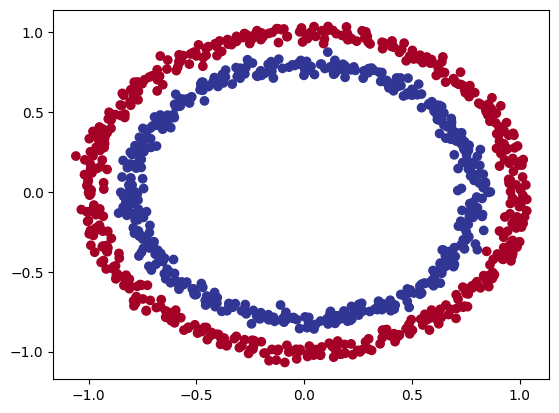

In [5]:
# Visualize, visualize, visualize
import matplotlib.pyplot as plt
plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu);

>**Note:** the data we're working with is often referred to as a toy dataset, a dataset that is small enough to experiment on but still sizeable enough to practice the fundamentals.

### 1.1. Check input and output shapes

In [6]:
X.shape, y.shape

((1000, 2), (1000,))

In [7]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


### 1.2 Turn data into tensors and create train and test splits

In [8]:
import torch
torch.__version__

'2.5.1+cu124'

Remember that for numpy is float64 but for torch is float32

In [9]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [10]:
type(X), X.dtype, y.dtype

(torch.Tensor, torch.float32, torch.float32)

In [11]:
# Split data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)
len(X_train), len(X_test), len(y_test), len(y_train)

(800, 200, 200, 800)

## 2. Building a model

Let's build a model to classify our blue and red dots.

To do so, we want to:
1. Setup device agnostic code so our code will run on an accelerator (GPU) if there is one
2. Construct a model (by sublcassing `nn.Module`)
3. Define a loss function and optimizer
4. Create a training and test loop

In [12]:
# Import PyTorch and nn
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

Now we've setup device agnostic code, let's create a model that:

1. Subclasses `nn.Module` (almost all models in PyTorch subclass `nn.Module`)
2. Create 2 `nn.Linear()` layers that are capable of handling the shapes of our data
3. Define a `forward()` method that outlines the forward pass (or forward computation) of the model
4. Instatiate an instance of our model class and send it to the target `device`

In [13]:
# 1. Construct a model that subclasses nn.Module
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    # 2. Creates 2 nn.Linear layers
    self.layer_1 = nn.Linear(in_features = 2, out_features=5) # takes in 2 features and upscales to 5 features
    self.layer_2 = nn.Linear(in_features=5, out_features=1) #takes in 5 features from previous layer and outputs a single feature (same shape as y)

  # 3. Define a forward() method that outlines the forward pass
  def forward(self, x):
    return self.layer_2(self.layer_1(x)) #x-> layer_1 -> layer_2 -> output

# 4. Instantiate an instance of our model class and send it to the targe device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [14]:
next(model_0.parameters()).device

device(type='cpu')

In [15]:
# Let's replicate the model above using nn.Sequential()
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [16]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.0742,  0.1582],
                      [ 0.1265,  0.5720],
                      [-0.1890,  0.1709],
                      [ 0.6061, -0.5244],
                      [ 0.3611, -0.1871]])),
             ('0.bias', tensor([ 0.3433,  0.6334, -0.3278,  0.2487,  0.0780])),
             ('1.weight',
              tensor([[-0.3628,  0.2164,  0.2535, -0.1403,  0.1002]])),
             ('1.bias', tensor([0.2337]))])

In [17]:
# Make predictions
with torch.inference_mode():
  untrained_pred = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_pred)}, Shape: {untrained_pred.shape}")
print(f"Length of test samples: {len(X_test)}, Shape: {X_test.shape}")
print(f"\nFirst 10 predictions:\n{torch.round(untrained_pred[:10])}")
print(f"\nFirst 10 labels:\n {y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200, 2])

First 10 predictions:
tensor([[0.],
        [0.],
        [0.],
        [0.],
        [-0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]])

First 10 labels:
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### 2.1 Setup loss function and optimizer

Which loss function or optimizer should you use?

Again... this is problem specific.

For example for regresssion you might want MAE or MSE. For classification you might want binary cross entropy or categorical cross entropy.

As a reminder, the loss function measures how *wrong* your models predictions are.

And for optimizers, two of the most common and useful are SGD and Adam, however PyTorch has many built-in functions.

* For the loss function, we're going to use `torch.nn.BECWithLogistLoss()`, for more on what binary cross entropy (BCE) is, check out this article.

In [18]:
# Create a loss function
# loss_fn = nn.BCELoss() # BCELoss = no sigmoid built-in
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid built-in

# Create an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [19]:
# Calculate accuracy
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)*100)
  return acc

## 3. Train a model

To train our model, we're going to need to build a training loop:
1. Forward pass
2. Calculate the loss
3. Optimizer zero gras
4. Loss backward (backpropagation)
5. Optimizer step (gradient descent)

### 3.1 Going from raw logits -> prediction probabilities -> prediction labels

Our model outputs are going to be raw **logits**.

We can convert these **logits** into prediction probabilites by passing them to some kind of activation function (e.g. sigmoid for binary classification and softmax for multiclass classification).

Then we can convert our model's prediction probabilites to **prediction labels** by either rounding them or taking the `argmax()`

In [20]:
# View the first 5 outputs of the forward pass on the test data
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[ 0.2643],
        [ 0.2934],
        [ 0.1141],
        [ 0.3072],
        [-0.0034]])

In [21]:
# Use the sigmoid activation function on our model logits to turn them into prediction probabilites
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5657],
        [0.5728],
        [0.5285],
        [0.5762],
        [0.4991]])

For our prediction probabilty values, we need to perform a range-style rounding on them:
* `y_pred_probs` >= 0.5, `y=1` (class 1)
* `y_pred_probs` < 0.5, `y=0` (class 0)

In [22]:
# Find the predicted labels
y_preds = torch.round(y_pred_probs)

# In full
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([1., 1., 1., 1., 0.])

### 3.2 Building a training and testing loop

In [23]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
  ### Training
  model_0.train()

  # 1. Forward pass
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) #turn logits -> pred_probs -> pred_labels

  # 2. Calculate loss/accuracy
  loss = loss_fn(y_logits, ##nn.BCEWithLogitsLoss expects raw logits as input
                 y_train)
  acc = accuracy_fn(y_true= y_train,
                    y_pred = y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward (backpropagation)
  loss.backward()

  # 5. Optimizer ste (gradient descent)
  optimizer.step()

  ### Testing
  model_0.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2. Calculate test loss/acc
    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy_fn(y_true = y_test,
                           y_pred = test_pred)

  # Print out what's happening
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% |Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.69607, Acc: 58.13% |Test loss: 0.69994, Test acc: 55.50%
Epoch: 10 | Loss: 0.69447, Acc: 54.12% |Test loss: 0.69786, Test acc: 49.50%
Epoch: 20 | Loss: 0.69380, Acc: 52.12% |Test loss: 0.69683, Test acc: 49.50%
Epoch: 30 | Loss: 0.69350, Acc: 51.62% |Test loss: 0.69627, Test acc: 50.00%
Epoch: 40 | Loss: 0.69333, Acc: 51.75% |Test loss: 0.69591, Test acc: 47.50%
Epoch: 50 | Loss: 0.69324, Acc: 51.50% |Test loss: 0.69567, Test acc: 47.00%
Epoch: 60 | Loss: 0.69317, Acc: 50.88% |Test loss: 0.69549, Test acc: 47.00%
Epoch: 70 | Loss: 0.69313, Acc: 51.12% |Test loss: 0.69535, Test acc: 48.50%
Epoch: 80 | Loss: 0.69309, Acc: 51.12% |Test loss: 0.69523, Test acc: 46.50%
Epoch: 90 | Loss: 0.69307, Acc: 51.38% |Test loss: 0.69514, Test acc: 46.50%
Epoch: 100 | Loss: 0.69305, Acc: 51.25% |Test loss: 0.69507, Test acc: 47.00%
Epoch: 110 | Loss: 0.69303, Acc: 51.00% |Test loss: 0.69500, Test acc: 46.00%
Epoch: 120 | Loss: 0.69302, Acc: 50.75% |Test loss: 0.69495, Test acc: 45.0

## 4. Make predictions and evaluate the model

From the metrics it looks like our model isn't learning anything...

So to inspect it let's make some predictions and make them visual!

In other words, "Visualize, visualize, visualize!"

To do so, we're goint to import a function called `plot_decision_boundary()` - https://github.com/mrdbourke/pytorch-deep-learning/blob/main/helper_functions.py



In [24]:
import requests
from pathlib import Path

# Download helper function from Learn PyTorch repo (if it's not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_function.pu alreday exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_function.pu alreday exists, skipping download


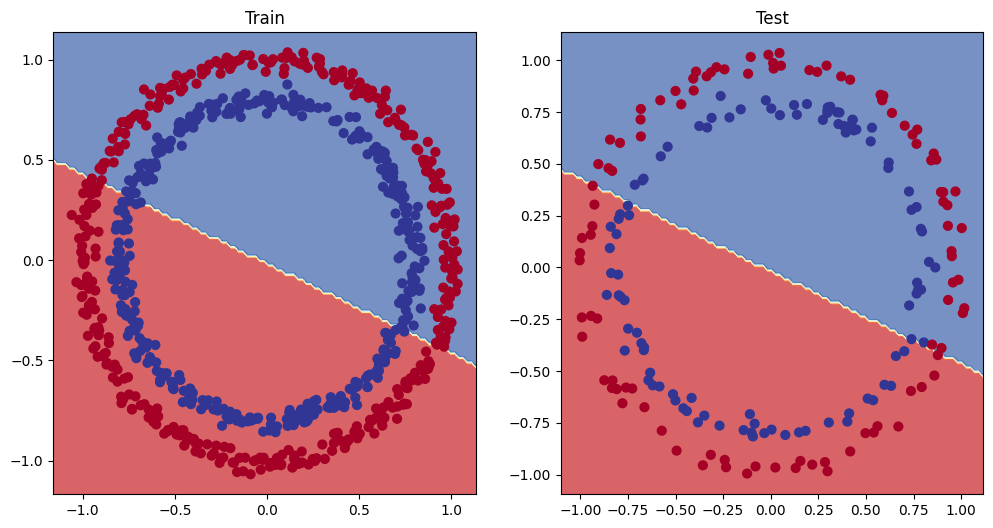

In [25]:
# Plot decision boundary
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0,X_test, y_test)


## 5. Improving a model (from a model perspective)

* Add more layers - give the model more chances to learn about patterns in the data
* Add more hidden units -  go from 5 hidden units to 10 hidden units
* Fit for longer
* Changing the activation functions
* Change the learning rate
* Change the loss function

These options are all from a model's perspective because they deal directly with the model, rather than the data.

And because these options are all values we (as machine learning engineers and data scientists) can change, they are referred to as **hyperparameters**.

Let's try and improve our model by:
* Adding more hidden units: 5 -> 10
* Increase the number of layers: 2 -> 3
* Increase the number of epochs: 100 - 1000

In [26]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)

  def forward(self, x):
    return self.layer_3(self.layer_2(self.layer_1(x)))
    # this way of writin operations leverages speed ups whee possible behind the scenes

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [27]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()

# Create an optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr = 0.1)

In [28]:
# Write a training and evaluation loop for model_1
torch.manual_seed(42)

# Set the number of epochs
epochs=100

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
  ### Training
  model_1.train()

  # 1. Forward pass
  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # 2. Calculate loss/accuracy
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true = y_train,
                    y_pred = y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backwards
  loss.backward()

  # 5. Optimizer step
  optimizer.step()

  ### Testing
  model_1.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    # 2. Calculate loss accuracy
    test_loss = loss_fn (test_logits, y_test)
    test_acc = accuracy_fn(y_test, test_pred)

    # Print out what's hapening
    if epoch %10 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.69396, Accuracy: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 10 | Loss: 0.69369, Accuracy: 50.25% | Test loss: 0.69270, Test acc: 50.00%
Epoch: 20 | Loss: 0.69351, Accuracy: 50.12% | Test loss: 0.69283, Test acc: 49.50%
Epoch: 30 | Loss: 0.69339, Accuracy: 50.50% | Test loss: 0.69297, Test acc: 48.00%
Epoch: 40 | Loss: 0.69329, Accuracy: 50.38% | Test loss: 0.69310, Test acc: 49.00%
Epoch: 50 | Loss: 0.69322, Accuracy: 49.88% | Test loss: 0.69324, Test acc: 50.00%
Epoch: 60 | Loss: 0.69317, Accuracy: 49.38% | Test loss: 0.69336, Test acc: 51.50%
Epoch: 70 | Loss: 0.69312, Accuracy: 49.38% | Test loss: 0.69348, Test acc: 50.50%
Epoch: 80 | Loss: 0.69309, Accuracy: 50.12% | Test loss: 0.69359, Test acc: 50.00%
Epoch: 90 | Loss: 0.69307, Accuracy: 50.50% | Test loss: 0.69370, Test acc: 48.50%


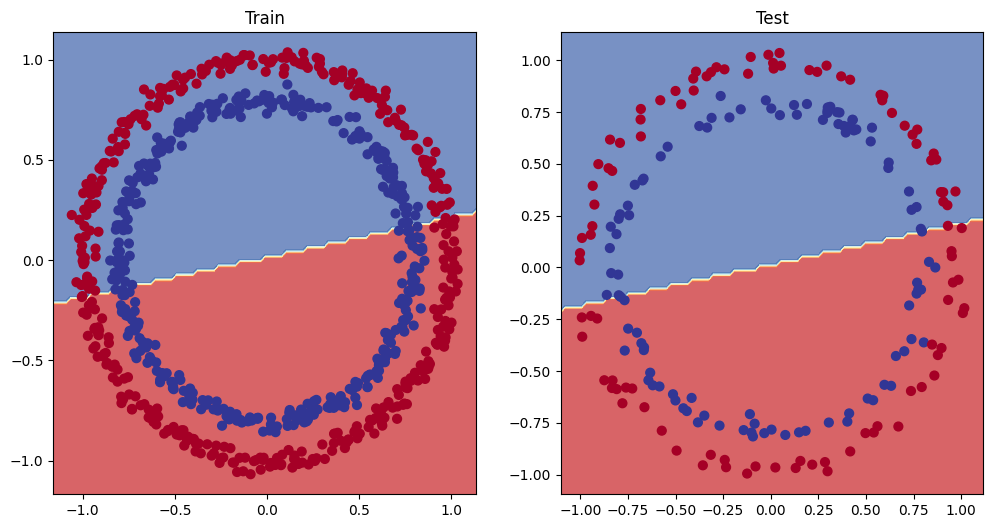

In [29]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

### 5.1 Preparing data to see if our model can fit a straight line

One way to troubleshoot to a larger problem is to test out a smaller problem.

In [30]:
# Create some data (same as notebook 01)
weight = 0.7
bias = 0.2
start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias

# Check the data
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.2000],
         [0.2070],
         [0.2140],
         [0.2210],
         [0.2280]]))

In [31]:
# Create train and test splits
train_split = int(0.8* len(X_regression))
X_train_regression, y_train_regresssion = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

# Check the len of each
len(X_train_regression), len(y_train_regresssion), len(X_test_regression), len(y_test_regression)

(80, 80, 20, 20)

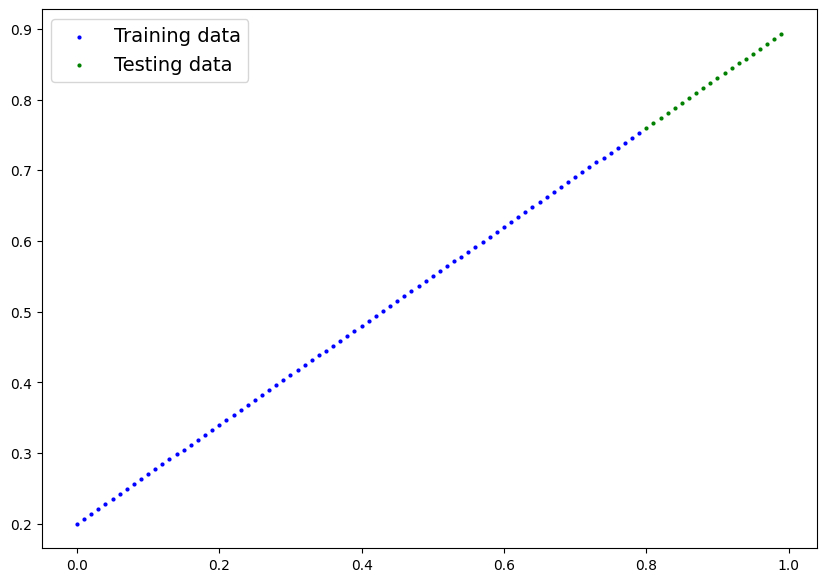

In [32]:
plot_predictions(train_data=X_train_regression,
                 train_labels = y_train_regresssion,
                 test_data = X_test_regression,
                 test_labels = y_test_regression)

###5.2 Adjusting `model_1` to fit a straight line

In [33]:
# Same architecture as model_1 (but using nn.Sequential)
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [34]:
# Loss and optimizer
loss_fn = nn.L1Loss()
optimizer=torch.optim.SGD(model_2.parameters(),
                          lr=0.1)

In [35]:
# Train the model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put the data on the target device
X_train_regression, y_train_regresssion = X_train_regression.to(device), y_train_regresssion.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

#Training
for epoch in range(epochs):
  y_pred = model_2(X_train_regression)
  loss = loss_fn(y_pred, y_train_regresssion)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  #Testing
  model_2.eval()
  with torch.inference_mode():
    test_pred = model_2(X_test_regression)
    test_loss = loss_fn(test_pred, y_test_regression)

  # Print out what's happening
  if epoch % 100 ==0:
    print(f"Epoch: {epoch} | Train loss: {loss:.5f}, Test loss: {test_loss:.5f}")

Epoch: 0 | Train loss: 0.65986, Test loss: 0.44143
Epoch: 100 | Train loss: 0.07265, Test loss: 0.17564
Epoch: 200 | Train loss: 0.05237, Test loss: 0.16393
Epoch: 300 | Train loss: 0.06145, Test loss: 0.15643
Epoch: 400 | Train loss: 0.06222, Test loss: 0.14886
Epoch: 500 | Train loss: 0.05545, Test loss: 0.14210
Epoch: 600 | Train loss: 0.05314, Test loss: 0.13932
Epoch: 700 | Train loss: 0.05057, Test loss: 0.12423
Epoch: 800 | Train loss: 0.05227, Test loss: 0.12270
Epoch: 900 | Train loss: 0.06090, Test loss: 0.12687


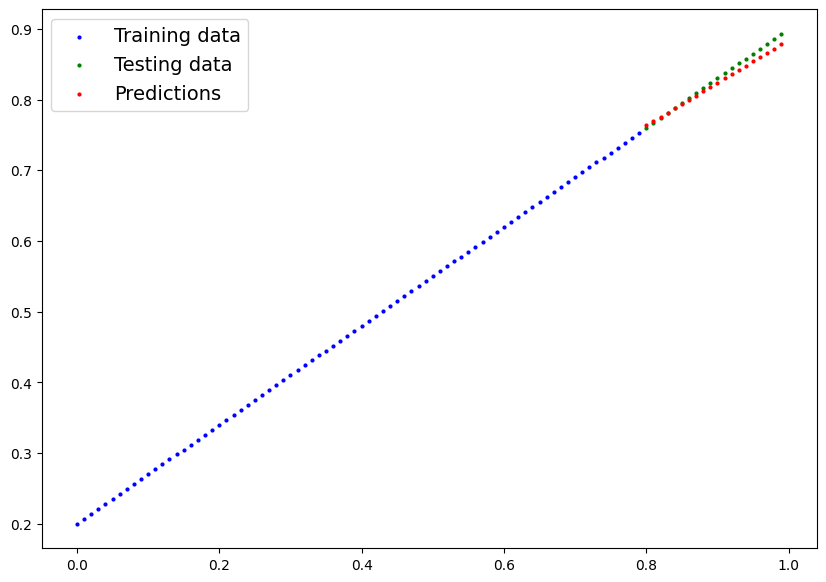

In [36]:
# Turn on evaluation mode
model_2.eval()

# Make predictions (inference)
with torch.inference_mode():
    y_preds = model_2(X_test_regression)

# Plot data and predictions with data on the CPU (matplotlib can't handle data on the GPU)
# (try removing .cpu() from one of the below and see what happens)
plot_predictions(train_data=X_train_regression.cpu(),
                 train_labels=y_train_regresssion.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(),
                 predictions=y_preds.cpu());

##6. The missing piece of our model: non-linearity

" What patterns could you draw if you were given an infinite amound of a straight and non-straigh lines?"

Or in machine learning terms, an infinite (but really it is finite) of linear and non-linear functions?


### 6.1 Recreating non-linear data (red and blue circles)

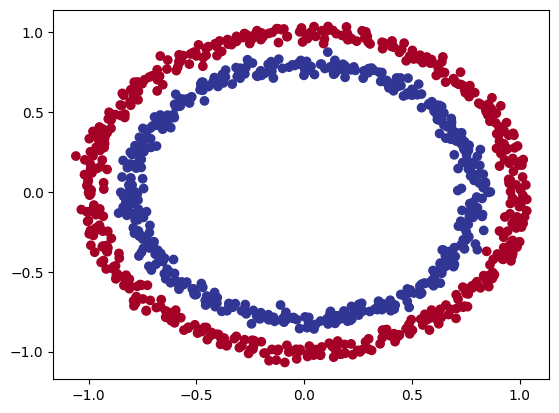

In [37]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.RdYlBu);


In [38]:
# Convert data to tensors and then to train and test splits
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.2,
                                                    random_state =42)
X_train[:5], y_train[:5]


(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

### 6.2 Building a model with non-linearity

* Linear = straight line
* Non-linear = non-straight lines

In [39]:
# Build a model with non-linear activation functions
from torch import nn
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU() # relu is a non-linear activation function

  def forward(self, x):
    # Where should be put our non-linear activation functions?
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [40]:
# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_3.parameters(), lr=0.001)

### 6.3 Training a model with non-linearity

In [41]:
# Fit the model
torch.manual_seed(42)
epochs = 1000

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # 1. Forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels

    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_3.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_3(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # 2. Calculate loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69295, Accuracy: 50.00% | Test Loss: 0.69310, Test Accuracy: 50.00%
Epoch: 100 | Loss: 0.68481, Accuracy: 52.88% | Test Loss: 0.68289, Test Accuracy: 57.00%
Epoch: 200 | Loss: 0.66289, Accuracy: 64.50% | Test Loss: 0.65978, Test Accuracy: 65.00%
Epoch: 300 | Loss: 0.60675, Accuracy: 78.38% | Test Loss: 0.60703, Test Accuracy: 76.50%
Epoch: 400 | Loss: 0.50024, Accuracy: 95.12% | Test Loss: 0.51360, Test Accuracy: 94.00%
Epoch: 500 | Loss: 0.38035, Accuracy: 98.88% | Test Loss: 0.40550, Test Accuracy: 98.50%
Epoch: 600 | Loss: 0.26408, Accuracy: 99.75% | Test Loss: 0.29234, Test Accuracy: 99.50%
Epoch: 700 | Loss: 0.18558, Accuracy: 99.62% | Test Loss: 0.21730, Test Accuracy: 99.50%
Epoch: 800 | Loss: 0.13569, Accuracy: 99.75% | Test Loss: 0.16587, Test Accuracy: 99.00%
Epoch: 900 | Loss: 0.10229, Accuracy: 99.88% | Test Loss: 0.13124, Test Accuracy: 99.50%


### 6.4 Evaluating a model trained with non-linear activation functions

In [42]:
# Make predictions
model_3.eval()
with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()

y_preds[:10], y_test[:10]

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

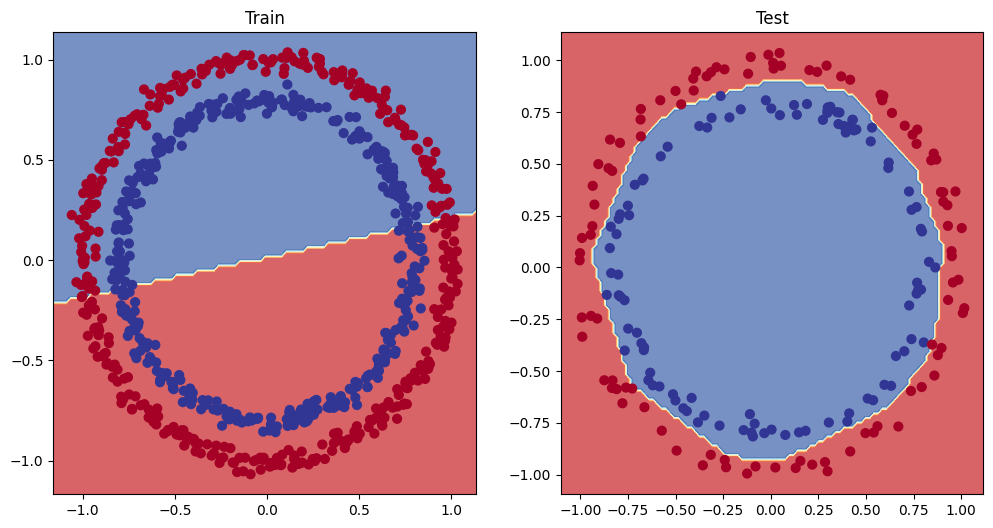

In [43]:
# Plot decision boundaries
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1,X_train,y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)

**Challenge:** Can you improve model_ to do better than 87% accuracy on the test data?

## 7. Replicating non-linear activation functions

Neural networks, rather than us telling the model what to learn, we give it the tools to discover patters in data and it tries to figure out the patterns on its own.

And these tools are linear & non-linear functions.

In [44]:
# Create a tensor
A = torch.arange(-10,10,1, dtype=torch.float32)
A.dtype

torch.float32

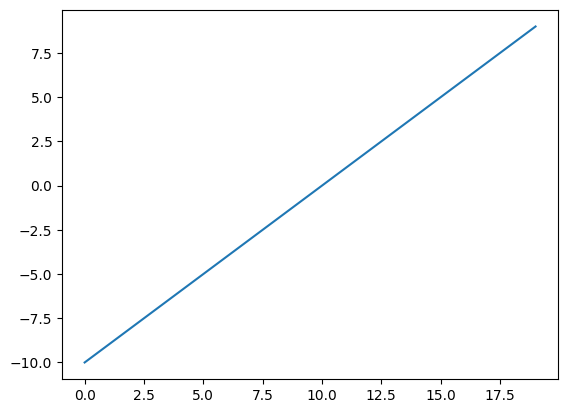

In [45]:
# Visualize the tensor
plt.plot(A);

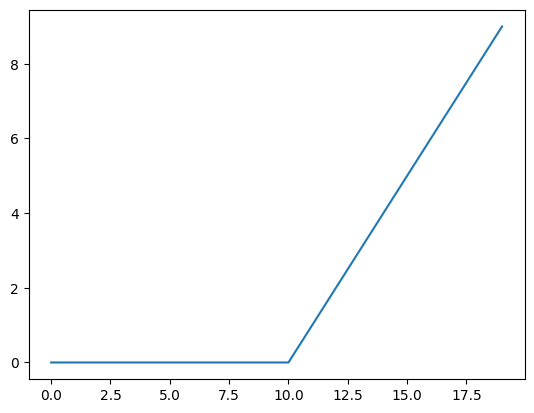

In [46]:
plt.plot(torch.relu(A));

In [47]:
def relu(x: torch.Tensor) -> torch.Tensor:
  return torch.maximum(torch.tensor(0),x) # inputs must be tensors

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

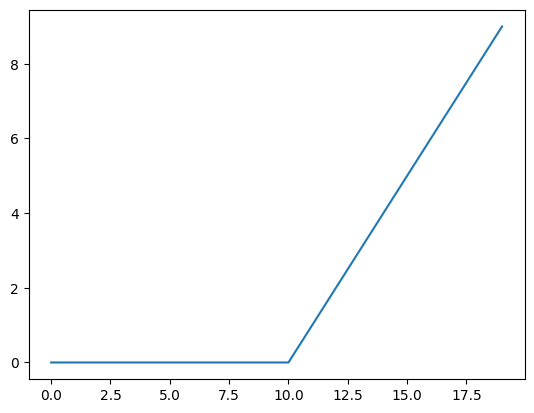

In [48]:
# Plot ReLu activatio function
plt.plot(relu(A));

In [49]:
# Create a custom sigmoid function
def sigmoid(x):
  return 1 / (1 + torch.exp(-x))

# Test custom sigmoid on toy tensor
sigmoid(A)

tensor([4.5398e-05, 1.2339e-04, 3.3535e-04, 9.1105e-04, 2.4726e-03, 6.6929e-03,
        1.7986e-02, 4.7426e-02, 1.1920e-01, 2.6894e-01, 5.0000e-01, 7.3106e-01,
        8.8080e-01, 9.5257e-01, 9.8201e-01, 9.9331e-01, 9.9753e-01, 9.9909e-01,
        9.9966e-01, 9.9988e-01])

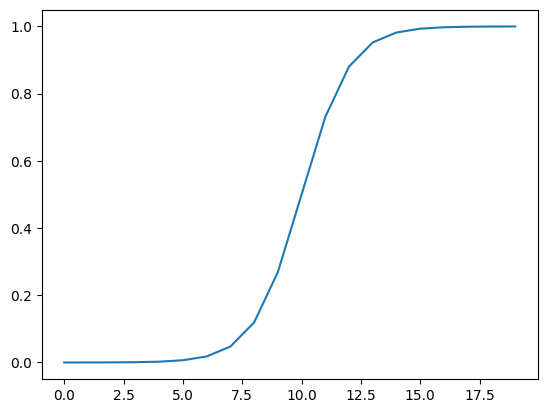

In [50]:
# Plot sigmoid activated toy tensor
plt.plot(sigmoid(A));

## 8. Putting it all together with a multi-class classification problem

* Binary classification = one thing or another (cat vs. dog, spam vs. not spam, fraud or not fraud)
* Multi-class classification = more than one thing or another (cats vs. dogs vs. birds)



### 8.1 Creating a toy multi-class dataset

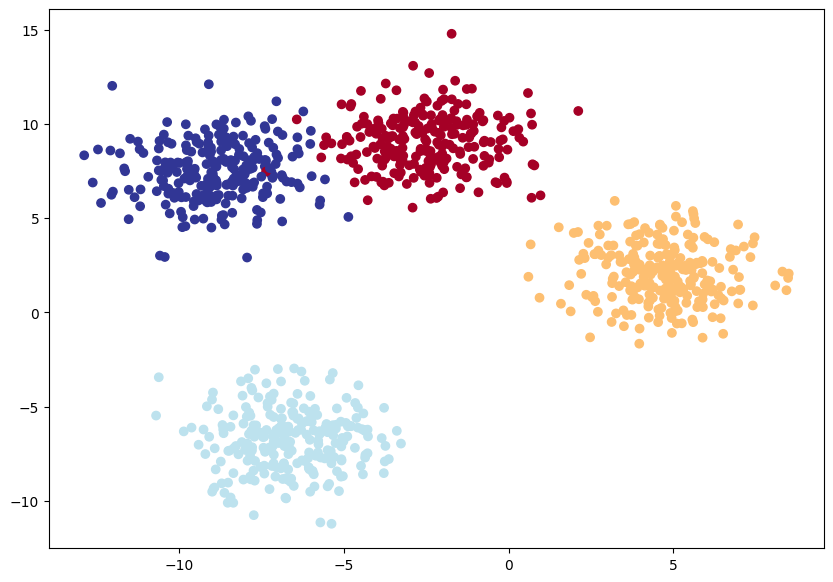

In [51]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creating
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5,
                            random_state = RANDOM_SEED)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# 3. Split into train and test
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size = 0.2,
                                                                        random_state = RANDOM_SEED)

# 4. Plot data(visualize, visualize, visualize)
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:,0], X_blob[:,1], c=y_blob, cmap=plt.cm.RdYlBu);


### 8.2 Building a multi-class classification model in PyTorch

In [52]:
# Create device agnostice code
device ="cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [53]:
# Build a multi-class classification model
class BlobModel(nn.Module):
  def __init__(self,input_features, output_features, hidden_units =8):
    """
    Initializes multi-class classification model

    Args:
      input_features(int): Number of input features to the model
      output_features(int): Number of outputs features(number of output classes)
      hidden_units(int): number of hidden units between layers, default 8
    """
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features= output_features)
    )

  def forward(self,x):
    return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(input_features=2,
                    output_features=4,
                    hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

### 8.3 Create a loss function and an optimzier

In [54]:
# Create loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(),
                            lr=0.01)

### 8.4 Getting predictions probabilities for a multi-class PyTorch model

In order to evaluate and train and test our model, we need to convert our model's outputs (logits) to prediction probabilities and then to prediction labels.

```
Logits (raw output of the model) -> Pred probs (use `torch.softmax`) -> Pred labels (take the argmax of the prediction probability)
```

In [55]:
# Let's get some raw outputs of our model (logits)
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test.to(device))

y_logits[:10]

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834],
        [-0.1497, -1.0617, -0.7107, -0.1645],
        [ 0.1539, -0.2887,  0.1520, -0.0109],
        [-0.2154, -1.1795, -0.9300, -0.2745],
        [ 0.2443, -0.2472,  0.1649,  0.0061],
        [-0.2329, -1.2120, -0.9849, -0.3004]])

In [56]:
# Convert our model's logit outputs to prediction probabilites
y_pred_probs = torch.softmax(y_logits, dim=1)
y_logits[:5], y_pred_probs[:5]

(tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
         [-0.0973, -0.9431, -0.5963, -0.1371],
         [ 0.2528, -0.2379,  0.1882, -0.0066],
         [-0.4134, -0.5204, -0.9303, -0.6963],
         [-0.3118, -1.3736, -1.1991, -0.3834]]),
 tensor([[0.3169, 0.3244, 0.1405, 0.2182],
         [0.3336, 0.1432, 0.2026, 0.3206],
         [0.3011, 0.1843, 0.2823, 0.2323],
         [0.3078, 0.2766, 0.1836, 0.2320],
         [0.3719, 0.1286, 0.1532, 0.3463]]))

In [57]:
# Convert our model's prediction probabilites to prediction labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds[:5]

tensor([1, 0, 0, 0, 0])

In [58]:
y_blob_test[:5]

tensor([1, 3, 2, 1, 0])

### 8.5 Creating a training loop and a testing loop for a multi-class PyTorch model

In [59]:
# Fit the multi-class model to the data
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
epochs = 100

# Put data to target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

# Loop through data
for epoch in range(epochs):
  ### Training
  model_4.train()

  y_logits = model_4(X_blob_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  loss = loss_fn(y_logits, y_blob_train)
  acc = accuracy_fn(y_true= y_blob_train,
                    y_pred = y_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  ### Testing
  model_4.eval()
  with torch.inference_mode():
    test_logits = model_4(X_blob_test)
    test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

    test_loss = loss_fn(test_logits, y_blob_test)
    acc = accuracy_fn(y_true=y_blob_test,
                      y_pred= test_pred)

  # Print out what's happening
  if epoch %10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")



Epoch: 0 | Loss: 1.15883, Acc: 38.50% | Test Loss: 1.14724, Test Acc: 100.00%
Epoch: 10 | Loss: 1.06493, Acc: 50.50% | Test Loss: 1.06841, Test Acc: 100.00%
Epoch: 20 | Loss: 0.98190, Acc: 57.50% | Test Loss: 0.99756, Test Acc: 100.00%
Epoch: 30 | Loss: 0.91138, Acc: 67.00% | Test Loss: 0.93600, Test Acc: 100.00%
Epoch: 40 | Loss: 0.85285, Acc: 87.50% | Test Loss: 0.88341, Test Acc: 100.00%
Epoch: 50 | Loss: 0.80430, Acc: 93.00% | Test Loss: 0.83851, Test Acc: 100.00%
Epoch: 60 | Loss: 0.76350, Acc: 94.50% | Test Loss: 0.79984, Test Acc: 100.00%
Epoch: 70 | Loss: 0.72848, Acc: 95.00% | Test Loss: 0.76595, Test Acc: 100.00%
Epoch: 80 | Loss: 0.69769, Acc: 95.00% | Test Loss: 0.73556, Test Acc: 100.00%
Epoch: 90 | Loss: 0.66978, Acc: 96.50% | Test Loss: 0.70758, Test Acc: 100.00%


## 8.6 Making and evaluating predictions with a PyTorch multi-class model

In [60]:
# Make predictions
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test)

# View the first 10 predictions
y_logits[:10]

tensor([[-1.5520,  1.7702, -3.0464, -2.5323],
        [-0.1348, -2.3305, -2.3721,  0.0972],
        [ 0.1727, -0.2462,  0.3317, -0.0312],
        [-0.9623,  1.3257, -1.6128, -1.5732],
        [ 0.0045, -2.1045, -3.4698, -0.7000],
        [-0.2060, -2.6914, -2.7822,  0.1333],
        [ 0.0815, -0.3303,  0.2308, -0.0381],
        [ 0.0133, -2.3748, -2.8843, -0.2998],
        [ 0.1518, -0.3270,  0.2987, -0.0882],
        [ 0.0534, -2.3575, -2.9727, -0.3954]])

In [61]:
# Go from logits -> Prediction probabilities
y_pred_probs = torch.softmax(y_logits,dim=1)
y_pred_probs[:10]

tensor([[0.0341, 0.9454, 0.0077, 0.0128],
        [0.4034, 0.0449, 0.0431, 0.5087],
        [0.2743, 0.1804, 0.3216, 0.2237],
        [0.0839, 0.8268, 0.0438, 0.0455],
        [0.6073, 0.0737, 0.0188, 0.3002],
        [0.3901, 0.0325, 0.0297, 0.5477],
        [0.2695, 0.1785, 0.3129, 0.2391],
        [0.5324, 0.0489, 0.0294, 0.3893],
        [0.2805, 0.1738, 0.3250, 0.2207],
        [0.5629, 0.0505, 0.0273, 0.3593]])

In [65]:
#Go from pred_probs to pred_labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds[:10]

# Compare first 10 model preds and test labels
print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])
Test accuracy: 97.0%


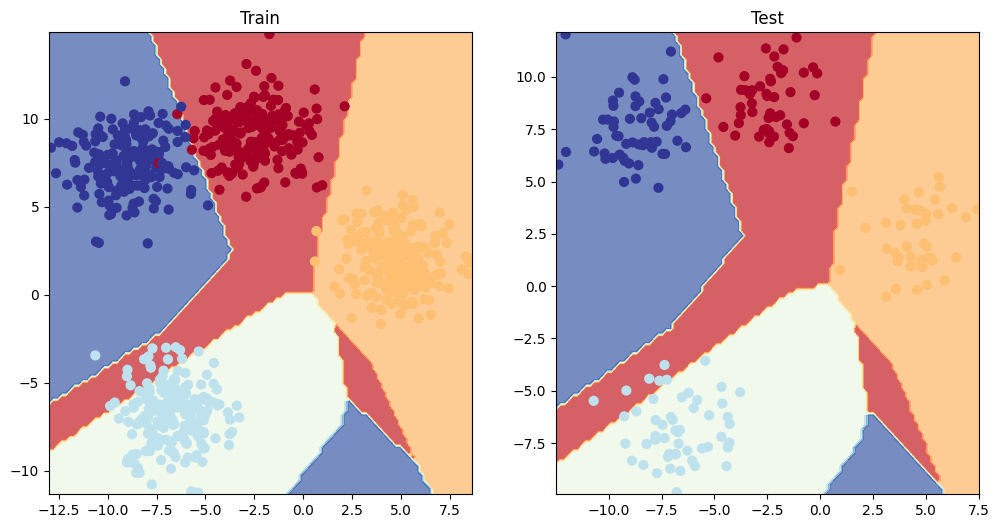

In [63]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

## 9. A few more classification metrics... (to evaluate our classification model)

* Accuracy - out of 100 samples, how many does our model get right? `torchmetrics.Accuracy()` or `sklearn.metrics.accuracy_score()`
* Precision
* Recall
* F1-score
* Confusion matrix
* Classification report


In [66]:
! pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 931.6/931.6 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 47.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 30.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 845.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninsta